In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns

import scipy
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import scipy.stats as ss
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.api import anova_lm
from statsmodels.stats.multicomp import (pairwise_tukeyhsd,
                                         MultiComparison)

import pingouin as pg
import warnings
warnings.filterwarnings("ignore")

#### Считываем данные для заданий

In [2]:
visit = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-k-korovina/shared/problem1-auth_data.csv', sep=";")
registration = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-k-korovina/shared/problem1-reg_data.csv', sep=";")

In [3]:
test = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-k-korovina/finalka/Проект_1_Задание_2.csv', sep=';')

## Проект: вариант 1
Представьте, что вы работаете в компании, которая разрабатывает мобильные игры. К вам пришел менеджер с рядом задач по исследованию нескольких аспектов мобильного приложения:

В первую очередь, его интересует показатель retention. Напишите функцию для его подсчета.
Помимо этого, в компании провели A/B тестирование наборов акционных предложений. На основе имеющихся данных определите, какой набор можно считать лучшим и на основе каких метрик стоит принять правильное решение.
Предложите метрики для оценки результатов последнего прошедшего тематического события в игре.

## Задание 1
Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока).

In [4]:
visit['auth_ts'] = pd.to_datetime(visit.auth_ts, unit='s')
registration['reg_ts'] = pd.to_datetime(registration.reg_ts, unit='s')

In [5]:
visit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9601013 entries, 0 to 9601012
Data columns (total 2 columns):
 #   Column   Dtype         
---  ------   -----         
 0   auth_ts  datetime64[ns]
 1   uid      int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 146.5 MB


In [6]:
registration.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype         
---  ------  --------------    -----         
 0   reg_ts  1000000 non-null  datetime64[ns]
 1   uid     1000000 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 15.3 MB


In [7]:
df = pd.merge(left=registration, right=visit, how='outer', on='uid')

In [8]:
df.head()

,reg_ts,uid,auth_ts
0,1998-11-18 09:43:43,1,1998-11-18 09:43:43
1,1999-07-22 22:38:09,2,1999-07-22 22:38:09
2,1999-07-22 22:38:09,2,1999-07-25 16:46:46
3,1999-07-22 22:38:09,2,1999-07-31 03:50:15
4,1999-07-22 22:38:09,2,1999-08-05 17:49:39


In [9]:
df.nunique()

reg_ts     1000000
uid        1000000
auth_ts    9180915
dtype: int64

In [10]:
active = df.assign(return_day = ((df['auth_ts'] - df['reg_ts']).dt.days))

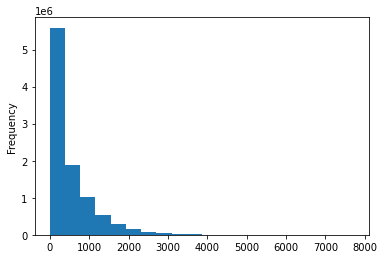

In [11]:
active.return_day.plot(kind='hist', bins=20);

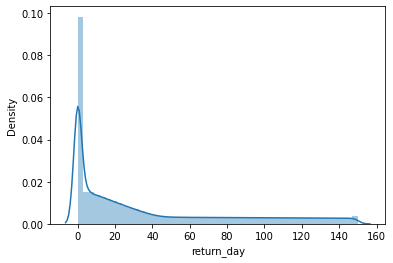

In [12]:
sns.distplot(active.query('return_day <= 150').return_day)

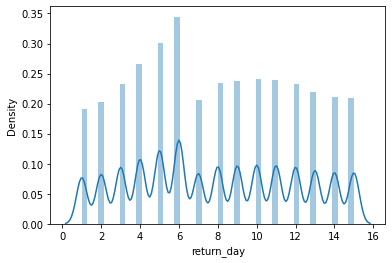

In [13]:
sns.distplot(active.query('1 <= return_day <=15').return_day);

Имеется необычное увеличение кол-ва игроков на 6 день

#### Напишем функцию retention на весь период

In [14]:
def retention(visit, registration, start=None, finish=None):
    '''Принимает таблицы visit и registration, возвращает когортный анализ с долей верувшихся пользователей'''
# Установим дату начала и окончания дат регестрации в игре
    if start is None:
        start = pd.to_datetime('2019-01-01')
    if finish is None:
        finish = pd.to_datetime('2019-01-18') #datetime.strptime(input('Дата окончания: '), '%Y-%m-%d').date()
    
    df = pd.merge(left=registration, right=visit, how='outer', on='uid')
# Расчитываем кол-во дней с даты региспрации для каждой строки
    active = df.assign(return_day = ((df['auth_ts'] - df['reg_ts']).dt.days))
# создаем столбец, который станет когортой
    active['reg_day'] = active['reg_ts'].dt.strftime('%Y-%m-%d')#когорта по дню: ('%Y-%m-%d'), месяцу:('%Y-%m') , году:('%Y')
    
# Отсортировываем по заданным датам
    active = active.query("reg_ts >= @start and reg_ts <= @finish")
# создаем таблицу в которой храним столбец с размером когорт
    c_size = active.groupby(['reg_day'], as_index=False).agg({'uid':'nunique'}).rename(columns={'uid':'cogort_size'})
    
# делим return_day на сегменты
    active['segment'] = pd.cut(active.return_day, [ 0, 1, 7, 14, 21, 28, 56, 70, 112, 168, 280, 448, 560, 8000], \
      labels=['1 day', '1 week', '2 week', '3 week', '4 week', '4-8 week', '8-10 week', \
             '10-16 week', '16-24 week', '24-40 week', '40-64 week', '64-80 week', '80-1142 week']) #'0 day', 
    active['segment'] = active['segment'].astype(str) # преобразуем категориальный тип в object
# группируем пользователей по дню регистрации, считаем кол-во уникальных пользователей в n день
    cogort = active.groupby(['reg_day', 'segment'], as_index=False).agg({'uid':'nunique'}).rename(columns={'uid':'n_users'})

# добавляем к основной таблице столбец с размером когорт
    cogort = cogort.merge(c_size, how='left', on='reg_day')
# создаем столбец с долей пользоаптелей, вошедших в n день
    cogort['ret'] = cogort.n_users / cogort.cogort_size
# разворачиваем таблицу
    cogort = cogort.pivot(index='reg_day', columns='segment', values='ret')
    cogort = cogort[['1 day', '1 week', '2 week', '3 week', '4 week', '4-8 week', '8-10 week', \
             '10-16 week', '16-24 week', '24-40 week', '40-64 week', '64-80 week', '80-1142 week']]

    return cogort

In [15]:
retention(visit, registration).head()

segment,1 day,1 week,2 week,3 week,4 week,4-8 week,8-10 week,10-16 week,16-24 week,24-40 week,40-64 week,64-80 week,80-1142 week
reg_day,,,,,,,,,,,,,
2019-01-01,0.034305,0.246998,0.216123,0.183533,0.152659,0.113208,0.048027,0.048027,0.048027,0.048027,0.048027,0.048027,0.048027
2019-01-02,0.036021,0.228130,0.202401,0.169811,0.133791,0.099485,0.053173,0.053173,0.053173,0.053173,0.053173,0.053173,0.053173
2019-01-03,0.030769,0.229060,0.193162,0.165812,0.136752,0.109402,0.054701,0.052991,0.052991,0.052991,0.052991,0.052991,0.052991
2019-01-04,0.044444,0.227350,0.215385,0.179487,0.152137,0.112821,0.039316,0.039316,0.039316,0.039316,0.039316,0.039316,0.039316
2019-01-05,0.032423,0.252560,0.223549,0.189420,0.153584,0.122867,0.059727,0.059727,0.059727,0.059727,0.059727,0.059727,0.059727


In [16]:
ur_style = (retention(visit, registration)
            .style
            .set_caption('User retention by cohort')  # добавляем подпись
            .background_gradient(cmap='viridis')  # раскрашиваем ячейки по столбцам
            .highlight_null('white')  # делаем белый фон для значений NaN
            .format("{:.2%}", na_rep=""))  # числа форматируем как проценты, NaN заменяем на пустоту
ur_style

segment,1 day,1 week,2 week,3 week,4 week,4-8 week,8-10 week,10-16 week,16-24 week,24-40 week,40-64 week,64-80 week,80-1142 week
reg_day,,,,,,,,,,,,,
2019-01-01,3.43%,24.70%,21.61%,18.35%,15.27%,11.32%,4.80%,4.80%,4.80%,4.80%,4.80%,4.80%,4.80%
2019-01-02,3.60%,22.81%,20.24%,16.98%,13.38%,9.95%,5.32%,5.32%,5.32%,5.32%,5.32%,5.32%,5.32%
2019-01-03,3.08%,22.91%,19.32%,16.58%,13.68%,10.94%,5.47%,5.30%,5.30%,5.30%,5.30%,5.30%,5.30%
2019-01-04,4.44%,22.74%,21.54%,17.95%,15.21%,11.28%,3.93%,3.93%,3.93%,3.93%,3.93%,3.93%,3.93%
2019-01-05,3.24%,25.26%,22.35%,18.94%,15.36%,12.29%,5.97%,5.97%,5.97%,5.97%,5.97%,5.97%,5.97%
2019-01-06,3.40%,22.62%,20.07%,16.84%,13.44%,10.03%,5.10%,5.10%,5.10%,5.10%,5.10%,5.10%,5.10%
2019-01-07,3.57%,25.17%,21.77%,17.86%,14.29%,11.39%,4.76%,4.76%,4.76%,4.76%,4.76%,4.76%,4.76%
2019-01-08,5.94%,24.45%,22.07%,18.00%,14.77%,11.38%,5.09%,5.09%,5.09%,5.09%,5.09%,5.09%,5.09%
2019-01-09,2.03%,21.02%,19.32%,14.92%,12.88%,10.00%,5.08%,5.08%,5.08%,5.08%,5.08%,5.08%,5.08%


Примерно после 10 недели значения по возвращаемости игроков выходят на плато

## N-Retantion
Посчитаем retantion по дням

In [17]:
def n_retantion(visit, registration):
    # соединяем таблицы
    df=pd.merge(left=registration, right=visit, how='outer', on='uid')
    # Расчитываем кол-во дней с даты региспрации для каждой строки
    active = df.assign(return_day = ((df['auth_ts'] - df['reg_ts']).dt.days))
    # создаем столбец, который станет когортой
    active['reg_day'] = active['reg_ts'].dt.strftime('%Y')

    # 
    calc_retention = []
    
    # Рассчитываем n_retention для каждого дня
    for return_day in days:
        # выбираем пользователей вернувшихся в определенный день
        id_with_n_days = active[active['return_day'] == return_day]['uid'].unique()

        # Рассчитываем n_retention для определенного дня
        calc_retention.append(len(id_with_n_days) / len(active['uid'].unique()))
        
    return calc_retention

In [18]:
def plt_show(days: list, retention: list, xs: list, title: str, add_text: bool = True):
    plt.figure(figsize=(14, 4))
    plt.plot(days, retention)

    plt.title(title)
    plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1.0))
    plt.gca().set(xlabel='Days', ylabel='% Retaining Users')

    for x in xs:
        plt.vlines(x=days[x], ymin=0, ymax=retention[x], linestyles='dotted')
        if add_text:
            plt.text(x=days[x], y=retention[x] + 0.05, s='{:.0%} (day {})'.format(retention[x], x))

    plt.show()

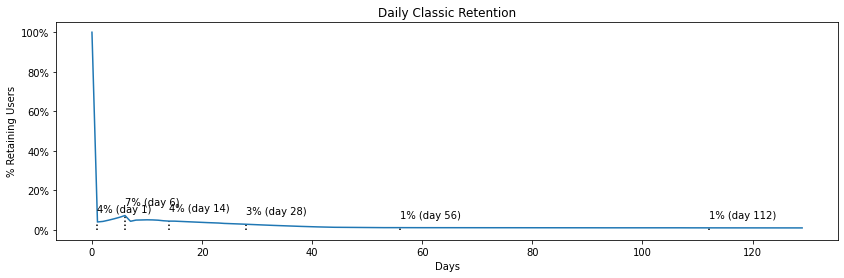

In [19]:
days = list(range(0, 130))
calc_retention = n_retantion(visit, registration)

plt_show(days, calc_retention, xs=[1, 6, 14, 28, 56, 112], title='Daily Classic Retention')

Посиотрим на выбросы ближе

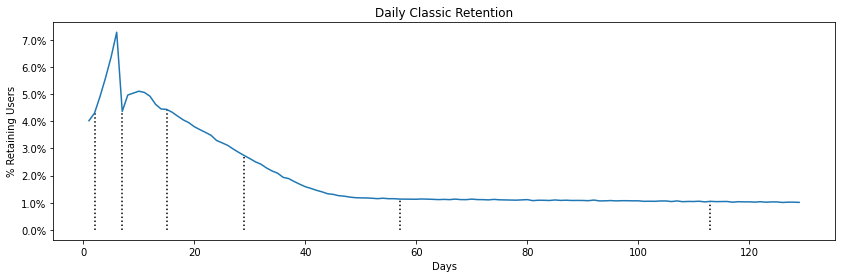

In [20]:
days = list(range(1, 130))
calc_retention = n_retantion(visit, registration)

plt_show(days, calc_retention, xs=[1, 6, 14, 28, 56, 112], title='Daily Classic Retention', add_text=False)

In [21]:
# Видим, что со следующего дня после первого захода в продукт/регестрации — вернулось только 4% пользоватклей.
# Имеется увеличение кол-ва пользователей на 6 день, 7% пользователей вернулись именно на этот день 
# Имеется 1% максимально лояльных пользователей, которые продолжают возврашаться даже спустя пол года

## Rolling Retention

In [22]:
def rolling_retention(visit, registration):
    # соединяем таблицы
    df=pd.merge(left=registration, right=visit, how='outer', on='uid')
    # Оставляем в колонке auth_ts только входы после регистрации и активных пользоватейлей(которые входили после регистрации)
    #active = df.query('reg_ts != auth_ts')  Убираю это условие, так как оно по всей вилимости ошибочно
    # Расчитываем кол-во дней с даты регистрации для каждой строки
    active = df.assign(return_day = ((df['auth_ts'] - df['reg_ts']).dt.days))

    # Создаем список для хранения rolling_retantion
    calc_rolling_retantion = []
    
    # Рассчитываем rolling_retention для каждого дня
    for return_day in days:
        # выбираем пользователей вернувшихся на день N или после него
        id_with_rolling_days = active[active['return_day'] >= return_day]['uid'].unique()

        # Рассчитываем rolling_retention для определенного дня
        calc_rolling_retantion.append(len(id_with_rolling_days) / len(active['uid'].unique()))
        
    return calc_rolling_retantion

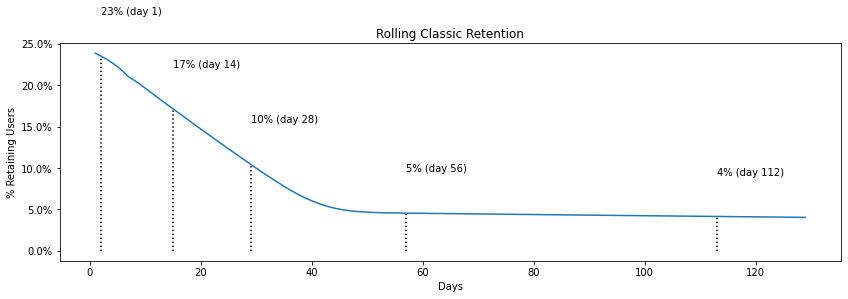

In [23]:
days = list(range(1, 130))
calc_rolling_retantion = rolling_retention(visit, registration)

plt_show(days, calc_rolling_retantion, xs=[1, 14, 28, 56, 112], title='Rolling Classic Retention')

Видим, что по результатам Rolling Classic Retention на следующий день после первого захода в продукт/регестрации — вернулось 24% пользоваелей.

## Задание 2
Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [24]:
test.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [25]:
test.shape

(404770, 3)

In [26]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404770 entries, 0 to 404769
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    404770 non-null  int64 
 1   revenue    404770 non-null  int64 
 2   testgroup  404770 non-null  object
dtypes: int64(2), object(1)
memory usage: 9.3+ MB


In [27]:
test.dtypes

user_id       int64
revenue       int64
testgroup    object
dtype: object

Посмотрим на размеры выборок

In [28]:
test.query('testgroup == "a"').revenue.count()

202103

In [29]:
test.query('testgroup == "b"').revenue.count()

202667

Посмотрим на распределение гистограммы по группам.
Видим, что из-за большого кол-ва 0 значений гистограмма получается малоинформативна

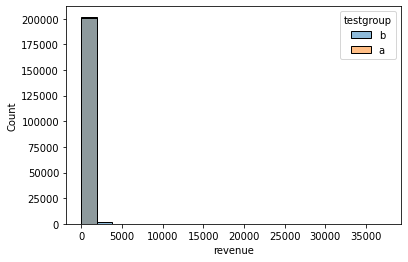

In [30]:
sns.histplot(test, x='revenue', hue='testgroup')

Из графика ничего не видно, попробуем убрать нулевые значения.

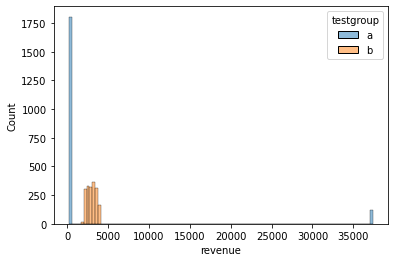

In [31]:
sns.histplot(test.query('revenue > 0'), x='revenue', hue='testgroup')

Посмотрим на распределение гистограммы по группам, где пользователи совершили покупку. На графике видим, что суммы покупок сильно различаются, в группе а они были в основном маленькие, либо очень большие, а в группе b они были в одном диапозоне, данные сильно отличаются 

In [32]:
test.query('testgroup == "b"').revenue.unique()

array([   0, 3797, 3768, ..., 2105, 3383, 3120])

In [33]:
test.groupby('testgroup').revenue.describe()

,count,mean,std,min,25%,50%,75%,max
testgroup,,,,,,,,
a,202103.0,25.413720,920.768137,0.0,0.0,0.0,0.0,37433.0
b,202667.0,26.751287,287.324162,0.0,0.0,0.0,0.0,4000.0


In [34]:
test.query('revenue > 0').groupby('testgroup').revenue.describe()

,count,mean,std,min,25%,50%,75%,max
testgroup,,,,,,,,
a,1928.0,2663.998444,9049.039763,200.0,257.0,311.0,361.0,37433.0
b,1805.0,3003.658172,572.619709,2000.0,2513.0,3022.0,3478.0,4000.0


#### Какие метрики мы можем оценить в этом A/B тесте:
1. CR конверсию в целевое действие, а именно покупку
2. AVG_bill - средний чек
3. REP_pur - возвращаемость клиентов
4. ARPPU Средний доход на платящего пользователя (то есть клиента)
5. ARPU Cредний доход с привлечённого пользователя

In [35]:
# Количество пользователей в группах
a_num = test.query("testgroup == 'a'").user_id.count()
b_num = test.query("testgroup == 'b'").user_id.count()

In [36]:
# Количество платящих клиентов (revenue > 0) в группах
a_client = test.query("testgroup == 'a' and revenue > 0").revenue.count()
b_client = test.query("testgroup == 'b' and revenue > 0").revenue.count()

In [37]:
# CR в группах
a_cr = a_client / a_num *100
b_cr = b_client / b_num *100

In [38]:
# Средний чек
avg_a = test.query("testgroup == 'a' and revenue > 0").revenue.mean()
avg_b = test.query("testgroup == 'b' and revenue > 0").revenue.mean()

In [39]:
# Повторные покупки в группах
rep_pur_a = a_client / test.query("testgroup == 'a' and revenue > 0").user_id.nunique()
rep_pur_b = b_client / test.query("testgroup == 'b' and revenue > 0").user_id.nunique()

In [40]:
# Расчет выручки в группах
revenue_a = test.query("testgroup == 'a'").revenue.sum()
revenue_b = test.query("testgroup == 'b'").revenue.sum()

In [41]:
# Расчет ARPPU в группах
arppu_a = round(revenue_a / a_client)
arppu_b = round(revenue_b / b_client)

In [42]:
# Расчет ARPU в группах
arpu_a = a_cr * arppu_a
arpu_b = b_cr * arppu_b

In [43]:
metr_test = pd.DataFrame({'user_num':[a_num, b_num],'client_num':[a_client, b_client], 'CR':[a_cr, b_cr],'Revenue':[revenue_a,revenue_b], \
                          'AVG_bill':[avg_a, avg_b], 'REP_pur':[rep_pur_a, rep_pur_b], 'ARPPU':[arppu_a, arppu_b], 'ARPU':[arpu_a,arpu_b] \
                         } 
                         , index=['control', 'test'])

In [44]:
metr_test

,user_num,client_num,CR,Revenue,AVG_bill,REP_pur,ARPPU,ARPU
control,202103,1928,0.953969,5136189,2663.998444,1.0,2664,2541.373458
test,202667,1805,0.890624,5421603,3003.658172,1.0,3004,2675.433100


### Проверим группы на нормальность
Вспомним, как выглядела гистограмма, паспределения не выглядят нормально

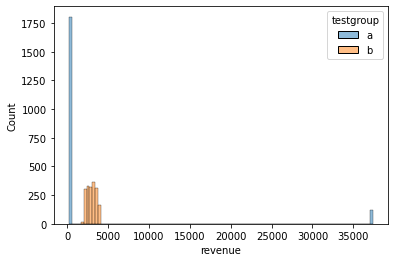

In [45]:
sns.histplot(test.query('revenue > 0'), x='revenue', hue='testgroup')

Посмотрим на боксплот.
Размер ящиков и длины усов сильно различаются, что говорит о некорректности сравнения таких групп

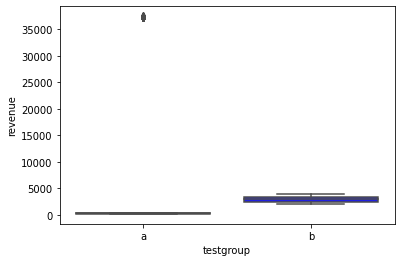

In [46]:
 sns.boxplot(x="testgroup" , y="revenue", data=test.query('revenue > 0'), palette=["r", "b"])

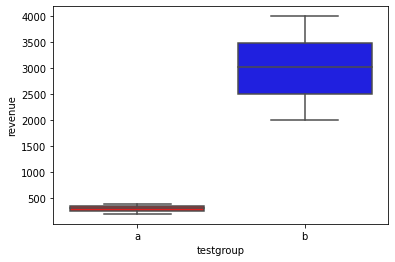

In [47]:
sns.boxplot(x="testgroup" , y="revenue", data=test.query('revenue > 0 & revenue < 10000'), palette=["r", "b"])

Думаю, что не стоит удалять выбросы, для достижения лучшего вида в распределении, 
так как выброс в группе 'а' состовляет почти 90% выручки у этой группы.

In [48]:
test.query('revenue > 1000').groupby('testgroup').revenue.sum() / test.groupby('testgroup').revenue.sum()

testgroup
a    0.893708
b    1.000000
Name: revenue, dtype: float64

In [49]:
test.query('revenue < 1000').groupby('testgroup').sum()

,user_id,revenue
testgroup,,
a,40912124939,545937
b,40610890428,0


In [50]:
a = test.query('testgroup == "a"').revenue 
b = test.query('testgroup == "b"').revenue

#### И дополнительно проверяем выборки тестом Шапиро 
хотим получить р-уровень значимости больше 0.05, для подтверждения нормальности

In [51]:
pg.normality(data=test, dv="revenue", group="testgroup")

,W,pval,normal
b,0.065882,0.0,False
a,0.008877,0.0,False


#### Резултаты теста указывают на то, что распределения не явлются нормальными

In [52]:
# Выберем метрику по которой хотим определить различия, используя стат тест.
metr_test

,user_num,client_num,CR,Revenue,AVG_bill,REP_pur,ARPPU,ARPU
control,202103,1928,0.953969,5136189,2663.998444,1.0,2664,2541.373458
test,202667,1805,0.890624,5421603,3003.658172,1.0,3004,2675.433100


### Оценим конверсию в покупку. 
Можем представить данные о выручке как категориальные, где revenue >0 -целевое действие, <br>
revenue < 0 - отсутсвие целевого действия, добавим еще один столбец (noclient_num) к таблице метрик. <br>
Теперь можем применить Хи-квадрат для оценки различий.<br>
Н0: Значимых отличий между конверсией в покупку в группах нет.<br>
Н1: Значимые отличия между конверсией в покупку в группах есть.<br>

<!-- Можем представить данные о выручке как категориальные, 
где revenue >0 -целевое действие, revenue < 0 - отсутсвие целевого действия, добавим еще один столбец (noclient_num) к таблице метрик. 
Теперь можем применить Хи-квадрат для оценки различий. 
Н0: Значимых отличий между конверсией в покупку в группах нет. 
Н1: Значимые отличия между конверсией в покупку в группах есть. -->

In [53]:
metr_test['noclient_num'] = metr_test.user_num - metr_test.client_num
a_noclient = a_num - a_client
b_noclient = b_num - b_client

In [54]:
# Create np array
T = np.array([[a_client, a_noclient], [b_client, b_noclient]])

In [55]:
ss.chi2_contingency(T,correction=False)[1]

0.0350285246428554

#### По результатам теста отвергаем Н0 и принимаем альтернативную гипотезу. Разница конверсии в покупку (6%) в группах является статистически значимой.

### Сравним ARPPU по группам

Поскольку распреледение ненормально и дисперсии в группах различаются, предлагаю применить bootstrap.

Применим bootstrap <br>
H0: Разницы между средним доходом от платящего пользователя в группах нет<br>
H1: Разница между средним доходом от платящего пользователя в группах есть

In [56]:
test_a_arppu = test.query('revenue>0 and testgroup =="a"')

In [57]:
test_b_arppu = test.query('revenue>0 and testgroup =="b"')

In [58]:
means_diff=[]

In [59]:
n=1000
# Извлекаем подвыборки
for i in range(n):
    a_mix = test_a_arppu.revenue.sample(frac=1, replace=True)
    a_mix_mean = a_mix.mean()
    
    b_mix = test_b_arppu.revenue.sample(frac=1, replace=True)
    b_mix_mean = b_mix.mean()

    # Добавляем в список means_diff разницу между средними
    means_diff.append(a_mix_mean - b_mix_mean)

In [60]:
means = pd.DataFrame(means_diff)

In [61]:
# Расчитываем границы доверительного интервала
left = pd.Series(means_diff).quantile(0.975)
right = pd.Series(means_diff).quantile(0.025)

quants = ([left, right])

In [ ]:
plt.hist(means[0], bins=50, color='grey')
plt.style.use('ggplot')
plt.axvline(x=0, color='blue', linestyle='--')
plt.axvline(x=left, color='red', linestyle='--')
plt.axvline(x=right, color='red', linestyle='--')
plt.xlabel('ARPPU')
plt.show()

#### По результатам теста принимаем Н0, статистически значимой разницы между ARPPU в группах нет. На графике 0 попадает в доверительный интервал.
#### Ответ: Несмотря на увеличение метрики ARPPU в тестовой группе, оно не является стат значимым, а CR в покупку ухудшилась стат значимо, принимая это во внимание, предлагается оставить акционные предложения из контрольной группы. 


## Задание 3
В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

Предположим, в другом событии мы усложнили механику событий так, к, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

### Ответ:

Предположим, что retention, который мы считали в первом задании был для этой игры. Тогда можно предположить, что увеличение возвращаемости игроков на 6 день связанно с тем, что в игре присутсвует такое событие для новых игроков, ограниченное по дням.
Результаты прошедшего события можно оценить с помощью следующих метрик: 

Клиенских:
Retention - покажет как события влияет на удержание клиентов
Дневная аудитория (DAU) — покажет количество уникальных пользователей, которые зашли в приложение в течение суток.
Месячная аудитория (MAU) — количество уникальных пользователей, которые зашли в приложение в течение месяца. По отношению средней дневной аудитории к месячной можно понимать частоту использования продукта.
avg. DAU/MAU = stickness ratio — коэффициент того, насколько часто пользователи, в течение одного периода (одного события), "остаются" в продукте
Воронка в следующий этап

Денежных:
Revenue - доход который компания получила за время события
CR- конверсия в покупку за время проведения события.
ARPPU - Средний доход на платящего пользователя, если он купил что-то за время события
ARPU - Средний доход на пользователя за время события

При усложнении механики событий, оставила бы те же метрики, но большее внимание уделила бы: Воронке в следующий уровень, avg. DAU/MAU = stickness ratio, чтобы сравнить это с перидом без аналогичного события и понять насколько сильно такая механика не нравится пользователям.